In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import json

# Define the neural network architecture
class ScoringModel(nn.Module):
    def __init__(self, num_inputs=26):  # Adjusted number of inputs
        super(ScoringModel, self).__init__()
        self.layer1 = nn.Linear(num_inputs, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 64)
        self.layer5 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, 1)
        self.leaky_relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.leaky_relu(self.layer1(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.layer2(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.layer3(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.layer4(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.layer5(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.output_layer(x))
        return x

# Load and prepare the dataset
file_path = 'goal_ticks.csv'

# Define column names based on the provided structure
column_names = [
    "kart_ID", "ball_X", "ball_Z", "ball_aim_X", "ball_aim_Z", "ball_node", "previous_X", "previous_Z", "ball_heading",
    "ball_appr_goal", "dist_to_ball", "kart_X", "kart_Z", "vel_X", "vel_Z", "speed", "steer", "accel", "kart_node", 
    "target_encoded", "target_pos_X", "target_pos_Z", "kart0_sector", "kart1_sector", "kart0_X", "kart0_Z", "kart1_X", 
    "kart1_Z", "has_powerup", "goal"
]

# Load the dataset
df = pd.read_csv(file_path, header=None, names=column_names)

# Drop the specified columns
df = df.drop(columns=["target_encoded", "target_pos_X", "target_pos_Z"])

# Print the first few rows of the dataframe to check if it loaded correctly
print("First few rows of the dataframe:")
print(df.head())

# Print the shape of the dataframe
print("Dataframe shape:", df.shape)

# Check for NaN values
nan_info = df.isna().sum()
print("NaN values in each column:")
print(nan_info)

# Check if any column has more than 0 NaN values
if nan_info.sum() > 0:
    # Handle NaNs: Drop rows with NaNs
    df = df.dropna()
    print("Dataframe shape after dropping NaNs:", df.shape)
else:
    print("No NaN values found in the dataframe.")

# Check for empty dataframe
if df.empty:
    raise ValueError("The dataframe is empty after dropping NaNs. Please check the CSV file.")

# Extract features and labels
X = df.iloc[:, :-1].values  # All columns except the last one (goal)
y = df['goal'].values  # The 'goal' column as binary

# Print the shape of features and labels
print("Features shape:", X.shape)
print("Labels shape:", y.shape)

# Check if the dataset is empty
if X.shape[0] == 0:
    raise ValueError("The dataset is empty. Please check the CSV file and ensure it contains valid data.")

# Normalize all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the scaler parameters for later use
scaler_params = {
    "mean": scaler.mean_.tolist(),
    "scale": scaler.scale_.tolist()
}

print("Scaler parameters:")
print(json.dumps(scaler_params, indent=4))

with open('scaler_parameters.json', 'w') as f:
    json.dump(scaler_params, f)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Keeping the target as a 2D tensor for BCELoss

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Prepare data loaders
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Initialize the model with 26 inputs
model = ScoringModel(num_inputs=26)

# Set up the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(train_loader, model, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if (epoch + 1) % 10 == 0:  # Print every 10 epochs
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}')

# Validation function
def validate_model(val_loader, model, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    print(f'Validation Loss: {total_loss / len(val_loader):.4f}')

# Train and validate the model
train_model(train_loader, model, criterion, optimizer, 10)
validate_model(val_loader, model, criterion)

# Save the trained model for deployment
model.eval()
model_scripted = torch.jit.script(model)  # Export to TorchScript
model_scripted.save("soccer_ai_model.pt")  # Save

# Print the weights of the output layer after training
print("Weights of the output layer after training:")
print(model.output_layer.weight)
print("Bias of the output layer after training:")

# Example output
example_input = torch.rand(1, X_train.shape[1])  # Generate a random example input
example_output = model(example_input)
print("Example output:", example_output.item())


First few rows of the dataframe:
   kart_ID    ball_X    ball_Z  ball_aim_X  ball_aim_Z  ball_node  previous_X  \
0        0  0.004125 -0.035641    0.004125    -2.56353        211   -0.009310   
1        0  0.004125 -0.035641    0.004125    -2.56353        211   -0.006590   
2        0  0.004125 -0.035641    0.004125    -2.56353        211   -0.006179   
3        0  0.004125 -0.035641    0.004125    -2.56353        211   -0.006167   
4        0  0.004274  1.002170    0.004638     3.53007        521    0.002200   

   previous_Z  ball_heading  ball_appr_goal  ...     accel  kart_node  \
0   -50.71680      0.000000               1  ...  0.699992        462   
1   -42.81540      0.000000               1  ...  0.699992        446   
2   -31.65030      0.000000               1  ...  0.699992        430   
3   -18.30690      0.000000               1  ...  0.699992        406   
4    -4.08362      0.000144               1  ...  0.699992        211   

   kart0_sector  kart1_sector   kart0_X  

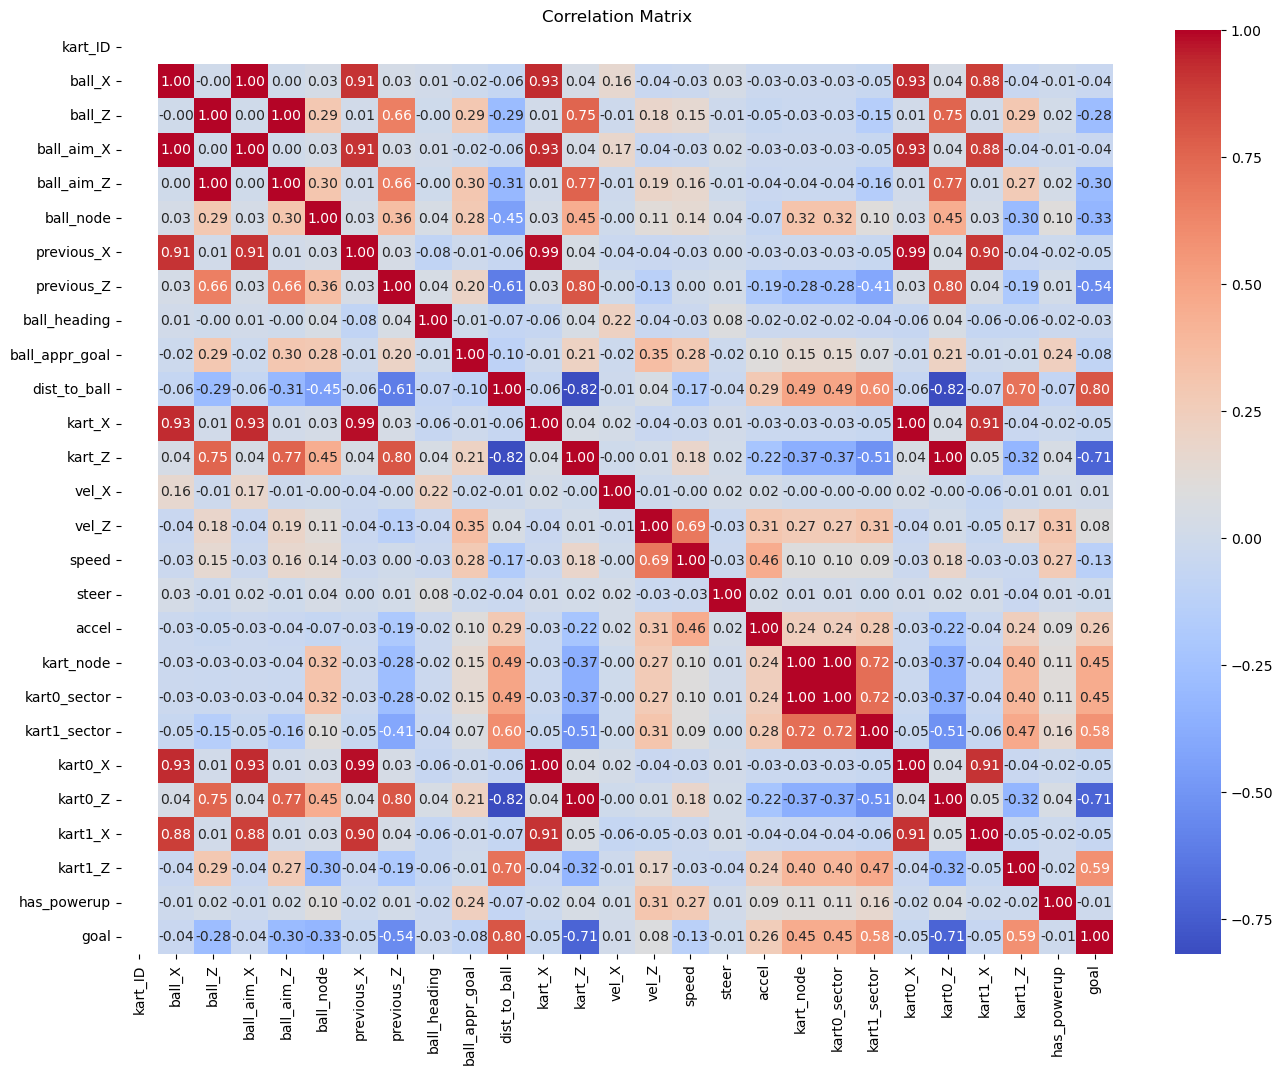

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = df.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()